In [107]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
TMPFIGPATH = "visualisation/figures/"
FIGPATH = "../../master_thesis/figures/"

import sys, os
import numpy as np
import pandas as pd
from datetime import datetime as dt
from collections import Counter
from sklearn.preprocessing import scale
from sklearn.feature_selection import VarianceThreshold
import bandicoot_dev as bc_d
from py_pcha.PCHA import PCHA
from sklearn import decomposition
import json
from build_dataset.analysis.compute_thetas import compute_thetas

In [2]:
# Can only be loaded remotely
from build_dataset.analysis.outlier_detection import Outlier_detector_svm, Outlier_detector_kd
from build_dataset.extractors.big_five_extractor import Big_five_extractor

In [3]:
tc0 = {
    'hours': range(24),
    'days': range(7),
    'spans': [
        ("01/01/14", "31/12/14")
    ],
    'weeks': range(53)
}
tc1 = {
    'hours': range(24),
    'days': range(7),
    'spans': [
        ("06/01/14", "24/01/14"),
        ("03/02/14", "16/05/14"),
        ("01/09/14", "05/12/14"),
        ("02/06/14", "20/06/14")
    ],
    'weeks': range(1, 4) + \
             range(5, 16) + \
             range(17, 20) + \
             range(22, 25) + \
             range(35, 40) + \
             range(41, 49)
}
tc2 = {
    'hours': range(24),
    'days': range(7),
    'spans': [
        ("17/05/14", "01/06/14"),
        ("06/12/14", "21/12/14")
    ],
    'weeks': range(20, 22) + \
             range(49, 52)
}
tc3 = {
    'hours': range(24),
    'days': range(7),
    'spans': [
        ("01/01/14", "05/01/14"),
        ("25/01/14", "02/02/14"),
        ("14/04/14", "20/04/14"),
        ("21/06/14", "30/08/14"),
        ("22/12/14", "31/12/14")
    ],
    'weeks': range(0, 1) + \
             range(4, 5) + \
             range(16, 17) + \
             range(25, 35) + \
             range(40, 41) + \
             range(52, 53)
}

## Compute features

In [71]:
class SufficiencyException(Exception):
    pass

def _threshold_test(user):
    def __recs_per_day(records):
        counter = len(records) * 1.0
        span = (max(records, key=lambda r: r.datetime).datetime - \
                min(records, key=lambda r: r.datetime).datetime).days
        if span == 0:
            return 0
        return counter/span
    
    thresholds = [
        (user.text_records, 2),
        (user.call_records, 1),
        (user.physical_records, 1),
        (user.screen_records, 20),
        (user.stop_records, 1)
    ]
    
    for records, thr in thresholds:
        if __recs_per_day(records) < thr:
            return False
    return True

def _compute_features(userid, tc="tc0", groupby="week", summary="special"):
    
    user = bc_d.read_csv(
        "%d" % userid, 
        call_path="build_dataset/data_cache/records/call/%s/" % tc,
        text_path="build_dataset/data_cache/records/text/%s/" % tc,
        physical_path="build_dataset/data_cache/records/physical/%s/" % tc,
        screen_path="build_dataset/data_cache/records/screen/%s/" % tc,
        stop_path="build_dataset/data_cache/records/stop/%s/" % tc, 
        network=False,
        describe=False
    )

    if not _threshold_test(user):
        raise SufficiencyException("User '%s' has too few records for analysis" % str(userid))
    
    user.start_time['any'] = dt.strptime('01/01/14', "%d/%m/%y")
    user.end_time['any'] = dt.strptime('01/01/15', "%d/%m/%y")
    
    indicators = bc_d.utils.all(
        user,
        groupby=groupby,
        summary=summary,
        dist=True,
        network=False,
        spatial=False
    )

    for ex in ['name', 'reporting']:
        del indicators[ex]

    return bc_d.utils.flatten(indicators), user

def _processed_users(tc):
    interaction_types = ["call", "text", "physical", "screen", "stop"]
    counter = Counter()
    for t in interaction_types:
        users = [int(f.split(".")[0]) for f in os.listdir("build_dataset/data_cache/records/%s/%s" % (t, tc))]
        counter.update(users)
    return [k for k,v in counter.items() if v == 5]

def _number_of_days(groupby):
    if groupby == "week":
        return 7
    if groupby == "month":
        return 30
    if groupby == "year":
        return 365

def _get_periods(tc, groupby):
    """Only works for tc0!"""
    period = _number_of_days(groupby)
    span = tc['spans'][0]
    delta = dt.strptime(span[1], "%d/%m/%y") - \
            dt.strptime(span[0], "%d/%m/%y")
    return int(np.ceil(delta.days/period)) + 1

def _interpolate_nans(X):
    """Overwrite NaNs with column value interpolations."""
    for j in range(X.shape[1]):
        mask_j = np.isnan(X[:,j])
        try:
            X[mask_j,j] = np.interp(np.flatnonzero(mask_j), np.flatnonzero(~mask_j), X[~mask_j,j])
        except ValueError:
            X[mask_j,j] = 0
    return X

def _variance_thresholding(X):
    """Return features with below threshold variance."""
    sel = VarianceThreshold(threshold=(0.5)).fit(X)
    return sel.get_support()
    

def make_dataset(groupby="week", tc="tc0", load_cached=True, interpolate_nans=False, variance_thresholding=False, summary="special"):
    if load_cached:
        try:
            X = np.load("data/X_2014_%s_%s.pickle" % (tc, groupby))
            Y = np.load("data/Y_2014_%s.pickle" % groupby)
            M = np.load("data/M_2014_%s.pickle" % groupby)
            feat_names = np.load("data/X_2014_%s_feat_names.pickle" % groupby)
            valid_users = np.load("data/XY_2014_%s_%s_valid_users.pickle" % (tc, groupby))
        except IOError:
            print "File not found. Building dataset..."
            load_cached = False
            
    if not load_cached:
        big_five = Big_five_extractor()
        users = _processed_users(tc)
        valid_users = []
        l = 0
        for u in sorted(users):  # <-- FOR LOOP START
            print "\n", u
    
            try:
                ds, user = _compute_features(u, tc=tc, groupby=groupby, summary=summary)
            except SufficiencyException as e:
                print e
                continue

            # Initiate
            if l == 0:
                if groupby == None:
                    M = len(ds)
                    N = 1
                else:
                    M = len(ds) + sum([1 for v in ds.values() if type(v[0]) is dict])  # Indicators
                    N = _get_periods(tc0, groupby)
                L = len(users)
                feat_names = []
                X = np.empty((N, M, L))
                Y = np.empty((1, 5, L))

            U = np.full((N, M), None)

            c = 0
            for m, (f, vals) in enumerate(ds.items()):
                if l == 0:
                    if groupby != None and type(vals[0]) is dict:
                        feat_names.append(f + "_mean")
                        feat_names.append(f + "_std")
                    else:
                        feat_names.append(f)
                
                if groupby != None:
                    for n, v in enumerate(vals):
                        # v is either [int, int, int, ...], or [dict, dict, dict, ...]
                        if type(v) is dict:
                            U[n, m + c] = v['mean']
                            U[n, m + c + 1] = v['std']
                            increment_c = True
                        else:
                            U[n, m + c] = v
                            increment_c = False
                else:
                    U[0, m + c] = vals
                    increment_c = False

                if increment_c:
                    c += 1

            try:
                X[:, :, l] = U
                Y[:, :, l] = big_five.main(u)
                valid_users.append(u)
                l+=1
            except:
                print "User", u, "skipped"

        X = X[:, :, :l]  # Not sure if it should be :l or :l+1
        Y = Y[0, :, :l]
        M = compute_thetas(Y.T, penalty='consensus')
        
        X.dump("data/X_2014_%s_%s.pickle" % (tc, groupby))
        Y.dump("data/Y_2014_%s.pickle" % groupby)
        M.dump("data/M_2014_%s.pickle" % groupby)
        np.array(feat_names).dump("data/X_2014_%s_feat_names.pickle" % groupby)
        np.array(valid_users).dump("data/XY_2014_%s_%s_valid_users.pickle" % (tc, groupby))
        
    if interpolate_nans:
        for l in range(X.shape[2]):
            mask_i = ~np.all(np.isnan(X[:, :, l]) | np.equal(X[:, :, l], 0), axis=1)
            X[mask_i, :, l] = _interpolate_nans(X[mask_i, :, l])
            
    if variance_thresholding:
        support = _variance_thresholding(scale(np.nanmean(X, axis=2)))
        X = X[:, support, :]
        print "Removed %d traits:" % np.sum(~support)
        for r in feat_names[~support]:
            print "  * %d - %s" % (list(feat_names).index(r), r)
        feat_names = feat_names[support]

    return X, Y, M, list(feat_names), list(valid_users)

print dt.now()
Xo, Yo, Mo, feat_nameso, valid_userso = make_dataset(groupby=None, tc="tc1", summary="default", load_cached=True, interpolate_nans=True, variance_thresholding=False)

2016-04-17 04:29:55.367561


In [72]:
feature_name_map = {
    'number_of_contacts_stop': 'Goes many different places',
    'number_of_contacts_text': 'Texts many different people',
    'number_of_contacts_call': 'Calls many different people',
    'number_of_contacts_text+call': 'Contacts many different people',
    'number_of_contacts_physical': 'Meets many different people',
    'number_of_interactions_stop': 'Goes places often',
    'number_of_interactions_text': 'Texts often',
    'number_of_interactions_call': 'Calls often',
    'number_of_interactions_text+call': 'Calls and texts often',
    'number_of_interactions_physical': 'Meets people often',
    'ratio_call_text_text+call': 'Prefers to call people over texting',
    'interactions_per_contact_stop': 'Goes places often compare to number of different places went',
    'interactions_per_contact_text': 'Texts people often compared to number of different people texted',
    'interactions_per_contact_call': 'Calls people often compared to number of different people called',
    'interactions_per_contact_physical': 'Meets people often compare to number of people met',
    'percent_ei_percent_interactions_text': 'Distributes texts evenly among friends',
    'percent_ei_percent_interactions_physical': 'Distributes meetings evenly among friends',
    'balance_of_interactions_text': 'Sends more texts than receives',
    'balance_of_interactions_call': 'Makes more calls then receives',
    'entropy_per_contacts_stop': 'Has unpredictable travel patterns',
    'entropy_per_contacts_text': 'Has unpredictable texting patterns',
    'entropy_per_contacts_call': 'Has unpredictable calling patterns',
    'entropy_per_contacts_physical': 'Has unpredictable social meeting patterns',
    'duration_stop': 'Spends long time at locations',
    'duration_text': 'Has long text conversations',
    'duration_screen': 'Has long phone usage sessions',
    'duration_call': 'Makes long calls',
    'duration_physical': 'Spends long times with people',
    'percent_ei_percent_durations_stop': 'Distributes time at different locations evenly',
    'percent_ei_percent_durations_call': 'Distributes calls evenly among contacts',
    'percent_ei_percent_interactions_text+call': 'Distributed texts and calls evenly among contacts',
    'percent_initiated_conversations_text+call_std': 'Starts more cell conversations with some people than with others',
    'percent_initiated_conversations_text+call_mean': 'Generally starts most cell conversations',
    'percent_concluded_conversations_text+call_std': 'Concludes more cell conversations with some people than with others',
    'percent_concluded_conversations_text+call_mean': 'Generally concludes most cell conversations',
    'overlap_conversations_per_contacts_text': 'Has text conversations with multiple people at the same time',
    'overlap_conversations_per_contacts_physical': 'Tends to hang out with multiple people at the same time',
    'response_delay_text_std': 'Will respond slower to texts for some people than others',
    'response_delay_text_mean': 'Generally responds to texts slowly',
    'response_delay_call_std': 'Will return missed calls slower for some people than others',
    'response_delay_call_mean': 'Generally responds slowly to missed calls',
    'response_rate_text+call_std': 'Tends to respond to texts and calls more often for some people than others',
    'response_rate_text+call_mean': 'Generally tends to respond to texts and calls',
    'percent_nocturnal_screen': 'Uses phone at night often',
    'percent_nocturnal_stop': 'Goes many places at night',
    'percent_nocturnal_physical': 'Meets many people at night',
    'interevent_time_screen': 'Can go long time without looking at phone',
    'ratio_social_screen_alone_screen_screen+physical': 'Tends to look at phone when among people',
    'percent_interactions_campus_physical+stop': 'Mostly meets people at the university',
    'percent_interactions_home_physical+stop': 'Mostly meets people at home',
    'percent_interactions_other_physical+stop': 'Mostly meets people outside of home and university',
    'percent_outside_campus_from_campus_physical+stop': 'Tends to meet friends from school outside of school',
    'percent_at_campus_stop': 'Shows up for class',
    'percent_at_home_stop': 'Stays at home',
    'percent_at_friday_bar_stop': 'Goes to the friday bar',
    'first_seen_response_rate_text+screen': 'Tends to respond to texts immediately',
    'percent_concluded_conversations_call_mean': 'Generally returns missed calls',
    'percent_concluded_conversations_call_std': 'Is more likely to return missed calls for some people than others',
    'percent_concluded_conversations_text_mean': 'Generally concludes most text conversations',
    'percent_concluded_conversations_text_std': 'Is more likely to conclude text conversations with some people than others',
    'percent_contacts_less_stop': 'Goes to many places only once',
    'percent_initiated_conversations_call_mean': 'Generally initiates most phone conversations',
    'percent_initiated_conversations_call_std': 'Is more likely to initiate phone conversations for some people than others',
    'percent_initiated_conversations_text_mean': 'Generally initiate most text conversations',
    'percent_initiated_conversations_text_std': 'Is more likely to initiate text conversations with some people than others',
    'ratio_social_screen_alone_screen_physical+screen': 'Tends to look at phone when among people',
    'ratio_interactions_campus_other_physical+stop': 'Mostly meets people at campus',
    'interaction_autocorrelation_physical': 'Meets with people in weekly patterns',
    'overlap_conversations_physical': 'Tends to go in groups',
    'number_of_contacts_less_stop': 'Goes to many unique places',
    'number_of_contacts_less_physical': 'Tends to interact with strangers'
}

super_traits = {
    'number_of_contacts_stop': [('mobility', 1)],
    'number_of_contacts_text+call': [('social_impact', 1)],
    'number_of_interactions_stop': [('mobility', 1)],
    'number_of_interactions_text+call': [('social_engagement', 1)],
    'number_of_interactions_physical': [('social_engagement', 1)],
    'percent_ei_percent_durations_stop': [('mobility', 1)],
    'balance_of_interactions_text': [('social_control', 1)],
    'duration_stop': [('mobility', -1)],
    'duration_text': [('social_engagement', 1)],
    'duration_screen': [('phone_dependency', 1)],
    'duration_call': [('social_engagement', 1)],
    'duration_physical': [('social_engagement', 1)],
    'percent_initiated_conversations_text_std': [('social_control', 1)],
    'percent_initiated_conversations_text_mean': [('social_control', 1)],
    'percent_initiated_conversations_call_std': [('social_control', 1)],
    'percent_initiated_conversations_call_mean': [('social_control', 1)],
    'percent_concluded_conversations_text_std': [('social_control', 1)],
    'percent_concluded_conversations_text_mean': [('social_control', 1)],
    'overlap_conversations_physical': [('social_gregariousness', 1)],
    'response_delay_text_std': [('social_control', 1)],
    'response_delay_text_mean': [('social_responsiveness', -1)],
    'response_delay_call_std': [('social_control', 1)],
    'response_delay_call_mean': [('social_responsiveness', -1)],
    'response_rate_text+call_std': [('social_control', 1)],
    'response_rate_text+call_mean': [('social_responsiveness', -1)],
    'percent_nocturnal_screen': [('nocturnality', 1)],
    'percent_nocturnal_stop': [('nocturnality', 1)],
    'percent_nocturnal_physical': [('nocturnality', 1)],
    'interevent_time_screen': [('phone_dependency', -1)],
    'ratio_social_screen_alone_screen_physical+screen': [('social_engagement', -1)],
    'ratio_interactions_campus_other_physical+stop': [('social_engagement_uni', 1)],
    'percent_outside_campus_from_campus_physical+stop': [('social_engagement_uni', 1)],
    'percent_at_campus_stop': [('engagement_uni', 1)],
    'number_of_contacts_less_stop': [('adventurousness', 1)],
    'number_of_contacts_less_physical': [('adventurousness', 1)],
    'first_seen_response_rate_text+screen': [('social_responsiveness', -1)],
    'ratio_call_text_text+call': [('social_directness', 1)],
    'interaction_autocorrelation_physical': [('engagement_uni', 1), ('adventurousness', -1)]
}

### Clean feature names

In [110]:
', '.join(feat_names)

'number_of_contacts_stop, number_of_contacts_text+call, number_of_interactions_stop, number_of_interactions_text+call, number_of_interactions_physical, percent_ei_percent_durations_stop, balance_of_interactions_text, duration_stop, duration_text, duration_screen, duration_call, duration_physical, percent_initiated_conversations_text_std, percent_initiated_conversations_text_mean, percent_initiated_conversations_call_std, percent_initiated_conversations_call_mean, percent_concluded_conversations_text_std, percent_concluded_conversations_text_mean, overlap_conversations_physical, response_delay_text_std, response_delay_text_mean, response_delay_call_std, response_delay_call_mean, response_rate_text+call_std, response_rate_text+call_mean, percent_nocturnal_screen, percent_nocturnal_stop, percent_nocturnal_physical, interevent_time_screen, ratio_social_screen_alone_screen_physical+screen, ratio_interactions_campus_other_physical+stop, percent_outside_campus_from_campus_physical+stop, perce

In [116]:
non_informative = []

def cl(f):
    return '_'.join(('_'.join(f.split("__allweek__allday__"))).split("__"))

feat_names = [cl(f) for f in feat_nameso if cl(f) not in non_informative]
with open('data/X_2014_%s_feat_names.csv' % str(None), 'w') as outfile:
    outfile.write(', '.join(feat_names))
list(enumerate([feature_name_map[n] for n in feat_names]))

[(0, 'Goes many different places'),
 (1, 'Contacts many different people'),
 (2, 'Goes places often'),
 (3, 'Calls and texts often'),
 (4, 'Meets people often'),
 (5, 'Distributes time at different locations evenly'),
 (6, 'Sends more texts than receives'),
 (7, 'Spends long time at locations'),
 (8, 'Has long text conversations'),
 (9, 'Has long phone usage sessions'),
 (10, 'Makes long calls'),
 (11, 'Spends long times with people'),
 (12,
  'Is more likely to initiate text conversations with some people than others'),
 (13, 'Generally initiate most text conversations'),
 (14,
  'Is more likely to initiate phone conversations for some people than others'),
 (15, 'Generally initiates most phone conversations'),
 (16,
  'Is more likely to conclude text conversations with some people than others'),
 (17, 'Generally concludes most text conversations'),
 (18, 'Tends to go in groups'),
 (19, 'Will respond slower to texts for some people than others'),
 (20, 'Generally responds to texts slo

### Apply column variable transforms

In [74]:
for i, n in enumerate(feat_names):
    if n not in tr_scheme:
        print i, n

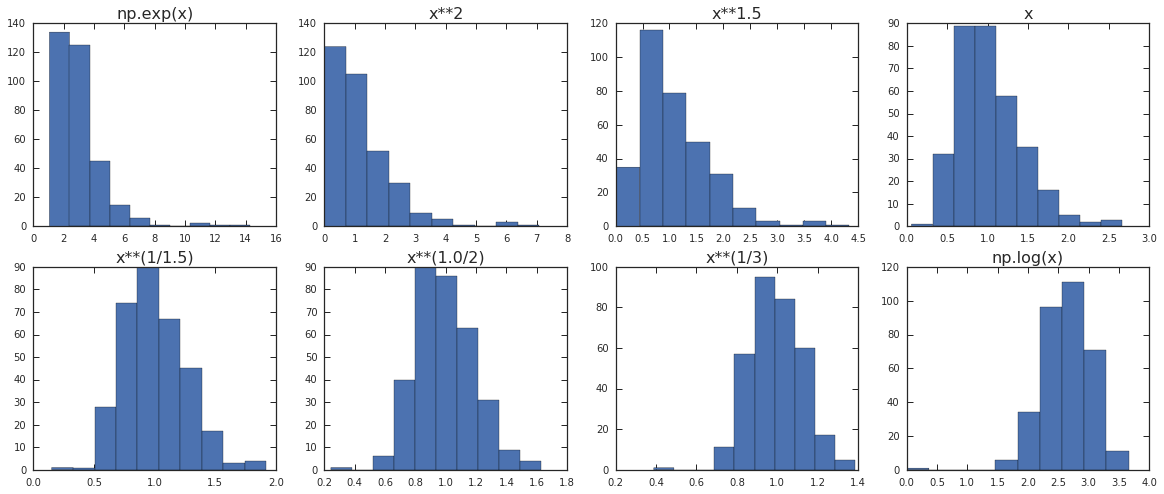

34 number_of_contacts_less_physical - Tends to interact with strangers


In [75]:
X = Xo[0, :, :].T  # Change shape (1, n, m)  -->  (n, m)

transforms = [
    (lambda x: np.exp(x), "np.exp(x)"),
    (lambda x: x**2, "x**2"),
    (lambda x: x**1.5, "x**1.5"),
    (lambda x: x, "x"),
    (lambda x: x**(1/1.5), "x**(1/1.5)"),
    (lambda x: x**(1.0/2), "x**(1.0/2)"),
    (lambda x: x**(1/3.0), "x**(1/3)"),
    (lambda x: np.log(x+0.01) - min(np.log(x+0.01)), "np.log(x)")
]

col_id = 34  # <-- CHOOSE FEATURE ID TO TEST
c = 0
plt.figure(figsize=(20, 8))
for t, s in transforms:
    try:
        tr = t(X[:, col_id])
        if tr[tr<0].any(0):
            print "Warning: transform contains neg. value"
            continue
        if tr[tr==np.inf].any(0):
            print "Warning: transform contains inf. value"
            continue
        c += 1
    except:
        pass
    plt.subplot(2, 4, c)
    plt.title(s, fontsize=16)
    plt.hist(tr)
    
plt.show()

print col_id, cl(feat_names[col_id]), "-", feature_name_map[cl(feat_names[col_id])]

In [76]:
tr_scheme = {
    'number_of_contacts_stop': lambda x: x,  # √
    #'number_of_contacts_text': lambda x: np.log(x),
    #'number_of_contacts_call': lambda x: np.log(x),
    'number_of_contacts_text+call': lambda x: np.log(x),  # √
    #'number_of_contacts_physical': lambda x: x,
    'number_of_interactions_stop': lambda x: x,  # √
    #'number_of_interactions_text': lambda x: np.log(x),
    #'number_of_interactions_call': lambda x: np.log(x),
    'number_of_interactions_text+call': lambda x: np.log(x),  # √
    'number_of_interactions_physical': lambda x: np.log(x),  # √
    #'interactions_per_contact_stop': lambda x: np.log(x),
    #'interactions_per_contact_text': lambda x: np.log(x),
    #'interactions_per_contact_call': lambda x: np.log(x),
    #'interactions_per_contact_physical': lambda x: np.log(x),
    'ratio_call_text_text+call': lambda x: np.log(x),  # √
    #'percent_ei_percent_interactions_text': lambda x: np.log(x),
    #'percent_ei_percent_interactions_physical': lambda x: np.log(x),
    'balance_of_interactions_text': lambda x: x,  # √
    #'balance_of_interactions_call': lambda x: x,
    #'entropy_per_contacts_stop': lambda x: x,
    #'entropy_per_contacts_text': lambda x: np.exp(x),
    #'entropy_per_contacts_call': lambda x: np.exp(x),
    #'entropy_per_contacts_physical': lambda x: np.exp(x),
    'duration_stop': lambda x: np.log(x),  # √
    'duration_text': lambda x: x,  # √
    'duration_screen': lambda x: np.log(x),  # √
    'duration_call': lambda x: np.log(x),  # √
    'duration_physical': lambda x: x,  # √
    'percent_ei_percent_durations_stop': lambda x: np.log(x),  # √
    #'percent_ei_percent_durations_call': lambda x: x,
    'percent_initiated_conversations_text_std': lambda x: x,  # √
    'percent_initiated_conversations_text_mean': lambda x: x,  # √
    'percent_initiated_conversations_call_std': lambda x: x,  # √
    'percent_initiated_conversations_call_mean': lambda x: x,  # √
    'percent_concluded_conversations_text_std': lambda x: x,  # √
    'percent_concluded_conversations_text_mean': lambda x: x,  # √
    'percent_concluded_conversations_call_std': lambda x: x,  # √
    'percent_concluded_conversations_call_mean': lambda x: x,  # √
    #'percent_initiated_conversations_text+call_std': lambda x: x,
    #'percent_initiated_conversations_text+call_mean': lambda x: x,
    #'percent_concluded_conversations_text+call_std': lambda x: x,
    #'percent_concluded_conversations_text+call_mean': lambda x: x,
    #'overlap_conversations_per_contacts_text': lambda x: np.log(x+0.0001),
    #'overlap_conversations_per_contacts_physical': lambda x: np.log(x+0.0001),
    'overlap_conversations_physical': lambda x: x,
    'response_delay_text_std': lambda x: x,  # √
    'response_delay_text_mean': lambda x: x,  # √
    'response_delay_call_std': lambda x: x,  # √
    'response_delay_call_mean': lambda x: x,  # √
    'response_rate_text+call_std': lambda x: x,  # √
    'response_rate_text+call_mean': lambda x: x,  # √
    'percent_nocturnal_screen': lambda x: x,  # √
    'percent_nocturnal_stop': lambda x: np.log(x),  # √
    'percent_nocturnal_physical': lambda x: np.log(x+0.01),  # √
    'interevent_time_screen': lambda x: np.log(x),  # √
    'ratio_social_screen_alone_screen_physical+screen': lambda x: np.log(x),  # √
    #'percent_interactions_campus_physical+stop': lambda x: x,
    'ratio_interactions_campus_other_physical+stop': lambda x: -np.log(1-x),  # √
    #'percent_interactions_home_physical+stop': lambda x: np.log(x+0.01),
    #'percent_interactions_other_physical+stop': lambda x: np.log(x),
    'percent_outside_campus_from_campus_physical+stop': lambda x: x**(1/2.0),  # √
    'percent_at_campus_stop': lambda x: x,  # √
    #'percent_at_home_stop': lambda x: x,
    #'percent_at_friday_bar_stop': lambda x: np.log(x+0.00001),
    'percent_contacts_less_stop': lambda x: x,  # √
    'percent_contacts_less_physical': lambda x: x,  # √
    'first_seen_response_rate_text+screen': lambda x: x,  # √
    'interaction_autocorrelation_physical': lambda x: x**(1/2.0),
    'number_of_contacts_less_stop': lambda x: x,
    'number_of_contacts_less_physical': lambda x: np.sqrt(x)
}

fi_scheme = {
    'number_of_contacts_stop': lambda x: x >= 0,
    'number_of_contacts_text': lambda x: x >= 0,
    'number_of_contacts_call': lambda x: x >= 0,
    'number_of_contacts_physical': lambda x: x >= 0,
    'number_of_interactions_stop': lambda x: x >= 0,
    'number_of_interactions_text': lambda x: x >= 0,
    'number_of_interactions_call': lambda x: x >= 0,
    'number_of_interactions_physical': lambda x: x >= 0,
    'interactions_per_contact_stop': lambda x: x >= 0,
    'interactions_per_contact_text': lambda x: x >= 0,
    'interactions_per_contact_call': lambda x: x >= 0,
    'interactions_per_contact_physical': lambda x: x >= 0,
    'percent_ei_percent_interactions_text': lambda x: x >= 0,
    'percent_ei_percent_interactions_physical': lambda x: x >= 0,
    'balance_of_interactions_text': lambda x: x >= 0,
    'balance_of_interactions_call': lambda x: x >= 0,
    'entropy_per_contacts_stop': lambda x: x >= 0,
    'entropy_per_contacts_text': lambda x: x >= 0,
    'entropy_per_contacts_call': lambda x: x >= 0,
    'entropy_per_contacts_physical': lambda x: x >= 0,
    'duration_stop': lambda x: x >= 0,
    'duration_text': lambda x: x >= 0,
    'duration_screen': lambda x: x >= 0,
    'duration_call': lambda x: x >= 0,
    'duration_physical': lambda x: x >= 0,
    'percent_ei_percent_durations_stop': lambda x: x >= 0,
    'percent_ei_percent_durations_call': lambda x: x >= 0,
    'percent_initiated_conversations_text_std': lambda x: x >= 0,
    'percent_initiated_conversations_text_mean': lambda x: x >= 0,
    'percent_initiated_conversations_call_std': lambda x: x >= 0,
    'percent_initiated_conversations_call_mean': lambda x: x >= 0,
    'percent_concluded_conversations_text_std': lambda x: x >= 0,
    'percent_concluded_conversations_text_mean': lambda x: x >= 0,
    'percent_concluded_conversations_call_std': lambda x: x >= 0,
    'percent_concluded_conversations_call_mean': lambda x: x >= 0,
    'percent_initiated_conversations_text+call_std': lambda x: x >= 0,
    'percent_initiated_conversations_text+call_mean': lambda x: x >= 0,
    'percent_concluded_conversations_text+call_std': lambda x: x >= 0,
    'percent_concluded_conversations_text+call_mean': lambda x: x >= 0,
    'overlap_conversations_per_contacts_text': lambda x: x >= 0,
    'overlap_conversations_per_contacts_physical': lambda x: x >= 0,
    'response_delay_text_std': lambda x: x >= 0,
    'response_delay_text_mean': lambda x: x >= 0,
    'response_delay_call_std': lambda x: x >= 0,
    'response_delay_call_mean': lambda x: x >= 0,
    'response_rate_text+call_std': lambda x: x >= 0,
    'response_rate_text+call_mean': lambda x: x >= 0,
    'percent_nocturnal_screen': lambda x: x >= 0,
    'percent_nocturnal_stop': lambda x: x >= 0,
    'percent_nocturnal_physical': lambda x: x >= 0,
    'interevent_time_screen': lambda x: x >= 0,
    'fraction_social_screen_alone_screen_screen+physical': lambda x: x >= 0,
    'percent_interactions_campus_physical+stop': lambda x: x >= 0,
    'percent_interactions_home_physical+stop': lambda x: x >= 0,
    'percent_interactions_other_physical+stop': lambda x: x >= 0,
    'percent_outside_campus_from_campus_physical+stop': lambda x: x >= 0,
    'percent_at_campus_stop': lambda x: x >= 0,
    'percent_at_home_stop': lambda x: x > 0.2,
    'percent_at_friday_bar_stop': lambda x: x >= 0,
    'percent_contacts_less_stop': lambda x: x >= 0,
    'percent_contacts_less_physical': lambda x: x >= 0,
    'first_seen_response_rate_screen+text': lambda x: x >= 0
}

In [77]:
Xt = X.copy()
for j, n in enumerate(feat_names):
    try:
        tr = tr_scheme[n]
    except KeyError:
        print "KeyError:", n, "not in tr_scheme. It should be... fix this. Using untransformed variable."
    Xt[:, j] = tr(X[:, j])
    
for i in range(Xt.shape[0]):
    for j, n in enumerate(feat_names):
        try:
            tr = tr_scheme[n]
        except KeyError:
            print "KeyError:", n, "not in tr_scheme. It should be... fix this. Using untransformed variable."
        

### User averages, zscore and save

In [78]:
#X_users_mean = np.nanmean(X[:, :, :],axis=0).T
Xtz = scale(Xt[~np.isnan(Xt).any(axis=1)])
np.savetxt("data/X_users_mean.csv", X_users_mean, delimiter=",")

#X_users_mean_tc1 = np.nanmean(X[tc1['weeks'], :, :],axis=0).T
#X_users_mean_tc1 = scale(X_users_mean_tc1[~np.isnan(X_users_mean_tc1).any(axis=1)])
#np.savetxt("data/X_users_mean_tc1.csv", X_users_mean_tc1, delimiter=",")

#X_users_mean_tc2 = np.nanmean(X[tc2['weeks'], :, :],axis=0).T
#X_users_mean_tc2 = scale(X_users_mean_tc2[~np.isnan(X_users_mean_tc2).any(axis=1)])
#np.savetxt("data/X_users_mean_tc2.csv", X_users_mean_tc2, delimiter=",")

#X_users_mean_tc3 = np.nanmean(X[tc3['weeks'], :, :],axis=0).T
#X_users_mean_tc3 = scale(X_users_mean_tc3[~np.isnan(X_users_mean_tc3).any(axis=1)])
#np.savetxt("data/X_users_mean_tc3.csv", X_users_mean_tc3, delimiter=",")

### Detect outliers

In [102]:
out_svm = Outlier_detector_svm(Xtz, hard=False, threshold=0, visualize=False, nu=0.1, gamma=0.25)
out_kd = Outlier_detector_kd(Xtz, visualize=False, threshold=0.05, bandwidth=2, kernel='gaussian')
outliers_svm = out_svm.main()
outliers_kd = out_kd.main()

Xtz_clean_svm = scale(np.delete(Xtz, outliers_svm, axis=0))
Y_clean_svm = np.delete(Yo.T, outliers_svm, axis=0)
M_clean_svm = np.delete(Mo, outliers_svm, axis=0)
Xtz_clean_kd = scale(np.delete(Xtz, outliers_kd, axis=0))
Y_clean_kd = np.delete(Yo.T, outliers_kd, axis=0)
M_clean_kd = np.delete(Mo, outliers_kd, axis=0)

print "[svm] Removed %d outliers, clean subset has %d samples" % (
    (X.shape[0]-Xtz_clean_svm.shape[0]), Xtz_clean_svm.shape[0])
np.savetxt("data/Xtz_clean_svm.csv", Xtz_clean_kd, delimiter=",")
np.savetxt("data/Y_clean_svm.csv", Y_clean_svm, delimiter=",")
np.savetxt("data/M_clean_svm.csv", M_clean_svm, delimiter=",")
np.savetxt("data/XtzYM_clean_svm_valid_users.csv", np.array(sorted(set(valid_userso) - set(outliers_svm))), delimiter=",")
print "[kd] Removed %d outliers, clean subset has %d samples" % (
    (X.shape[0]-Xtz_clean_kd.shape[0]), Xtz_clean_kd.shape[0])
np.savetxt("data/Xtz_clean_kd.csv", Xtz_clean_kd, delimiter=",")
np.savetxt("data/Y_clean_kd.csv", Y_clean_kd, delimiter=",")
np.savetxt("data/M_clean_kd.csv", M_clean_kd, delimiter=",")
np.savetxt("data/XtzYM_clean_kd_valid_users.csv", np.array(sorted(set(valid_userso) - set(e[0] for e in outliers_kd))), delimiter=",")

[svm] Removed 25 outliers, clean subset has 305 samples
[kd] Removed 16 outliers, clean subset has 314 samples


# Show archetypes

### PCA + PCHA for each individual tc

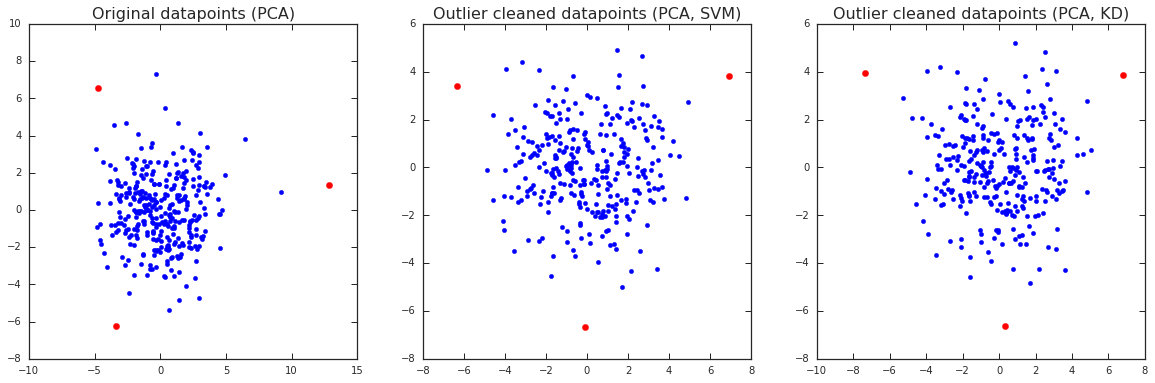

In [89]:
plt.figure(0, figsize=(20,6))

plt.subplot(1,3,1)
plt.title("Original datapoints (PCA)", fontsize=16)

subset = sorted(set(range(Xtz.shape[1])))# - set([15, 29, 39, 33, 34]))

pca = decomposition.PCA(n_components=2)
X0 = Xtz.copy()[:, subset]
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)

plt.subplot(1,3,2)
plt.title("Outlier cleaned datapoints (PCA, SVM)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = np.delete(Xtz, outliers_svm, axis=0)[:, subset]
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)

plt.subplot(1,3,3)
plt.title("Outlier cleaned datapoints (PCA, KD)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = np.delete(Xtz, outliers_kd, axis=0)[:, subset]
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)

plt.show()

# Pareto clustering

In [42]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import networkx as nx
from collections import defaultdict
from pareto_clustering.cluster.pareto_cluster import Pareto_cluster

### Cap too correlating features

del --x Spends long time at locations
cor --> Goes places often || -0.765379438101

del --x Is more likely to conclude text conversations with some people than others
cor --> Is more likely to initiate text conversations with some people than others || 0.654693088843

del --x Generally initiates most phone conversations
cor --> Is more likely to initiate phone conversations for some people than others || -0.829379721315

del --x Generally tends to respond to texts and calls
cor --> Generally concludes most text conversations || 0.624318537644

del --x Generally responds to texts slowly
cor --> Will respond slower to texts for some people than others || 0.764275403553

del --x Generally tends to respond to texts and calls
cor --> Tends to respond to texts and calls more often for some people than others || 0.780886451063



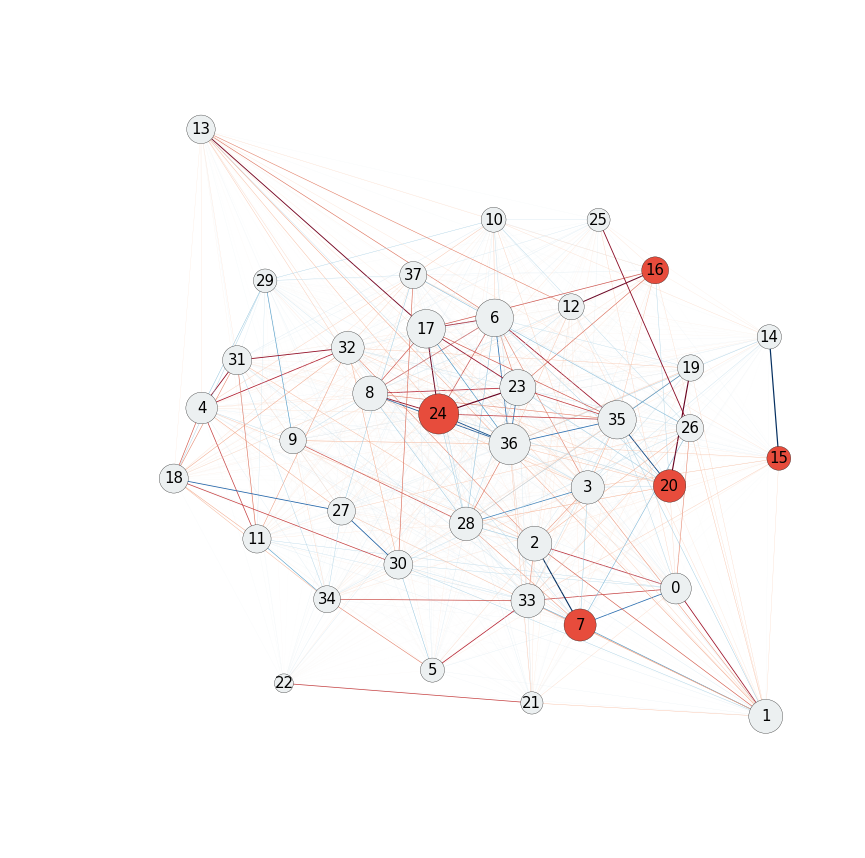

In [103]:
Xtz_clean_svm = np.loadtxt("data/Xtz_clean_svm.csv", delimiter=",")
Xtz_clean_svm_valid_users = np.loadtxt("data/Xtz_clean_svm_valid_users.csv", delimiter=",")
feat_names = np.load("data/X_2014_%s_feat_names.pickle" % None)

X = Xtz_clean_svm
valid_users = Xtz_clean_svm_valid_users

feat_blacklist = []

sigma = np.corrcoef(X.T)
remove_cols = []

G = nx.Graph()

cutoff = 0.6
for i in range(sigma.shape[0]):
    for j in range(sigma.shape[1]):
        
        G.add_edge(i, j, weight=abs(sigma[i, j]), color=sigma[i, j])
        
        if i >= j:# or j in remove_cols:
            continue
            
        if abs(sigma[i, j]) > cutoff:
            print "del --x %s" % feature_name_map[cl(feat_names[j])]
            print "cor --> %s ||" % feature_name_map[cl(feat_names[i])],
            #print "del --x %s" % cl(feat_names[j])
            #print "cor --> %s ||" % cl(feat_names[i]),
            print sigma[i, j]
            print
            
            remove_cols.append(j)

## ASSIGN
X = np.delete(X, remove_cols, axis=1)
feat_names = [cl(fn) for i, fn in enumerate(feat_names) if i not in remove_cols]


## SHOW GRAPH OF CORRELATION COEF MATRIX WITH CAP ENFORCED
plt.figure(figsize=(12,12))
plt.axis('off')
plt.tight_layout()

pos = nx.spring_layout(G, k=0.2)

edge_widths = np.log(np.array([abs(G[u][v]['weight']) for u,v in G.edges()])+1)*2
edge_colors = np.array([G[u][v]['color']  for u,v in G.edges()]).clip(min=-cutoff, max=cutoff)

degrees = [G.degree(weight='weight')[n] for n in G.nodes()]
node_sizes = (np.array(degrees)/np.mean(degrees)*30)**2
node_colors = ['#e74c3c' if n in remove_cols else '#ecf0f1' for n in G.nodes()]

label_names = dict((n, n) for n in G.nodes()) # ''.join(feat_names[n].split("_allweek__allday__"))

edges = nx.draw_networkx_edges(G, pos=pos, width=edge_widths, edge_color=edge_colors, edge_cmap=plt.cm.RdBu_r)
nodes = nx.draw_networkx_nodes(G, pos=pos, with_labels=False, node_size=node_sizes, node_color=node_colors)
labels = nx.draw_networkx_labels(G, pos=pos, font_size=15, labels=label_names)

plt.show()

In [49]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.5, min_samples=2, metric='precomputed').fit(1-sigma)
sorted(zip(db.labels_,feat_names), key=lambda x: x[0])

[(-1, 'number_of_interactions_stop'),
 (-1, 'number_of_interactions_text+call'),
 (-1, 'percent_ei_percent_durations_stop'),
 (-1, 'duration_text'),
 (-1, 'duration_call'),
 (-1, 'duration_physical'),
 (-1, 'percent_initiated_conversations_text_std'),
 (-1, 'percent_concluded_conversations_text_std'),
 (-1, 'percent_concluded_conversations_text_mean'),
 (-1, 'response_delay_call_std'),
 (-1, 'percent_nocturnal_screen'),
 (-1, 'percent_nocturnal_stop'),
 (-1, 'percent_outside_campus_from_campus_physical+stop'),
 (-1, 'percent_at_campus_stop'),
 (-1, 'number_of_contacts_less_stop'),
 (-1, 'number_of_contacts_less_physical'),
 (-1, 'interaction_autocorrelation_physical'),
 (0, 'number_of_contacts_stop'),
 (0, 'number_of_contacts_text+call'),
 (1, 'number_of_interactions_physical'),
 (1, 'first_seen_response_rate_text+screen'),
 (1, 'ratio_call_text_text+call'),
 (2, 'balance_of_interactions_text'),
 (2, 'duration_screen'),
 (2, 'percent_initiated_conversations_call_std'),
 (2, 'response_d

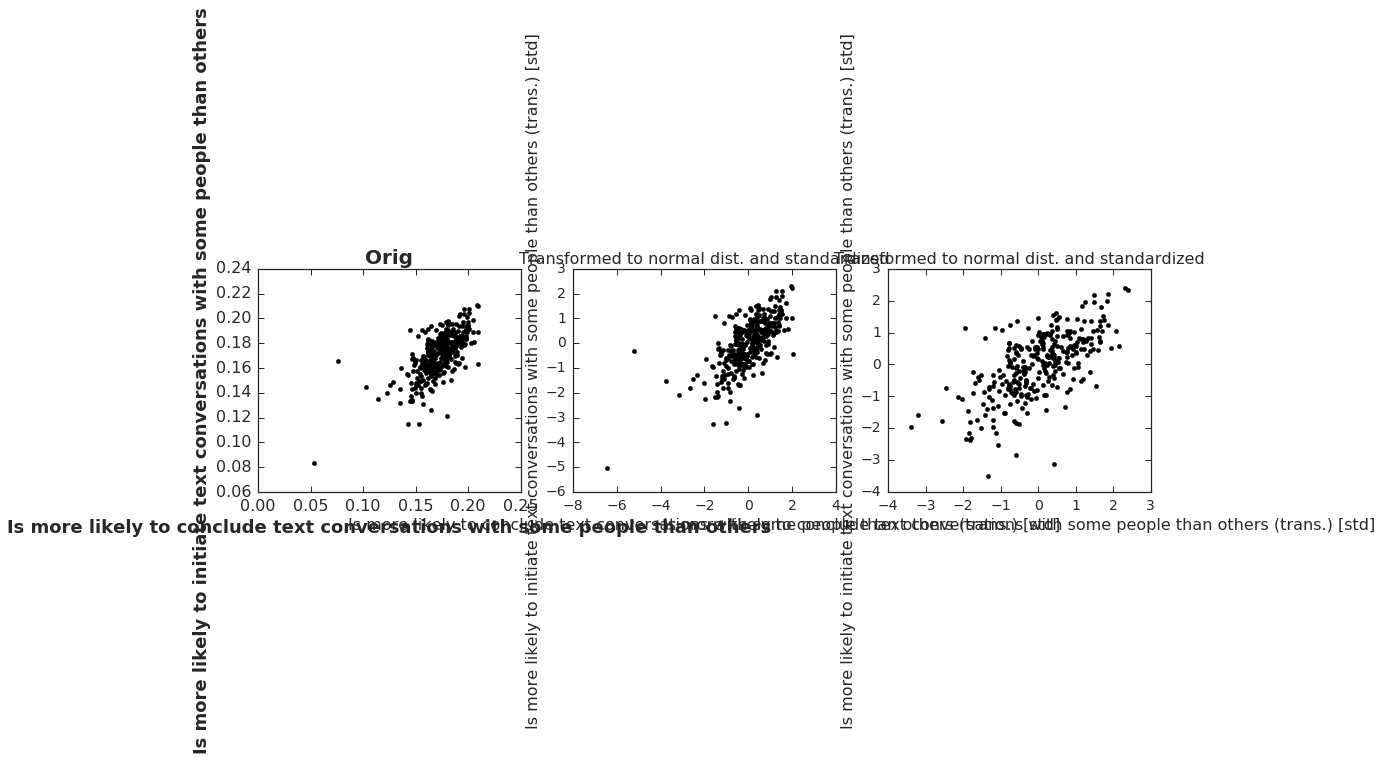

In [65]:
import re

#X1 = X_users_mean_tc0_clean_svm
X1 = Xo[0, :, :].T

import re
mystr = """del --x Is more likely to conclude text conversations with some people than others
cor --> Is more likely to initiate text conversations with some people than others || 0.645807458139"""

feat_i_n, feat_j_n = tuple([w.strip() for w in re.findall(r"[A-Z][\w ]+", mystr)])

#feat_i_n = 'Meets many people only once'
#feat_j_n = 'Contacts many different people'

feat_i = dict((v, k) for k, v in feature_name_map.items())[feat_i_n]
feat_j = dict((v, k) for k, v in feature_name_map.items())[feat_j_n]

i = map(cl, feat_nameso).index(feat_i)
j = map(cl, feat_nameso).index(feat_j)

plt.figure(figsize=(16, 4))
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})  # <-- STYLE

plt.subplot(1,3,1)
plt.title("Orig", fontsize=20, fontweight='bold')
plt.scatter(X1[:, i], X1[:, j], c="k")
plt.xlabel(feat_i_n, fontsize=18, fontweight='bold')
plt.ylabel(feat_j_n, fontsize=18, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1,3,2)
plt.title("Transformed to normal dist. and standardized", fontsize=16)
plt.scatter(scale(tr_scheme[feat_i](X1[:, i])), scale(tr_scheme[feat_j](X1[:, j])), c="k")
plt.xlabel("%s (trans.) [std]" % feat_i_n, fontsize=16)
plt.ylabel("%s (trans.) [std]" % feat_j_n, fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1,3,3)
plt.title("Transformed to normal dist. and standardized", fontsize=16)
plt.scatter(Xtz_clean_kd[:, i], Xtz_clean_kd[:, j], c="k")
plt.xlabel("%s (trans.) [std]" % feat_i_n, fontsize=16)
plt.ylabel("%s (trans.) [std]" % feat_j_n, fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

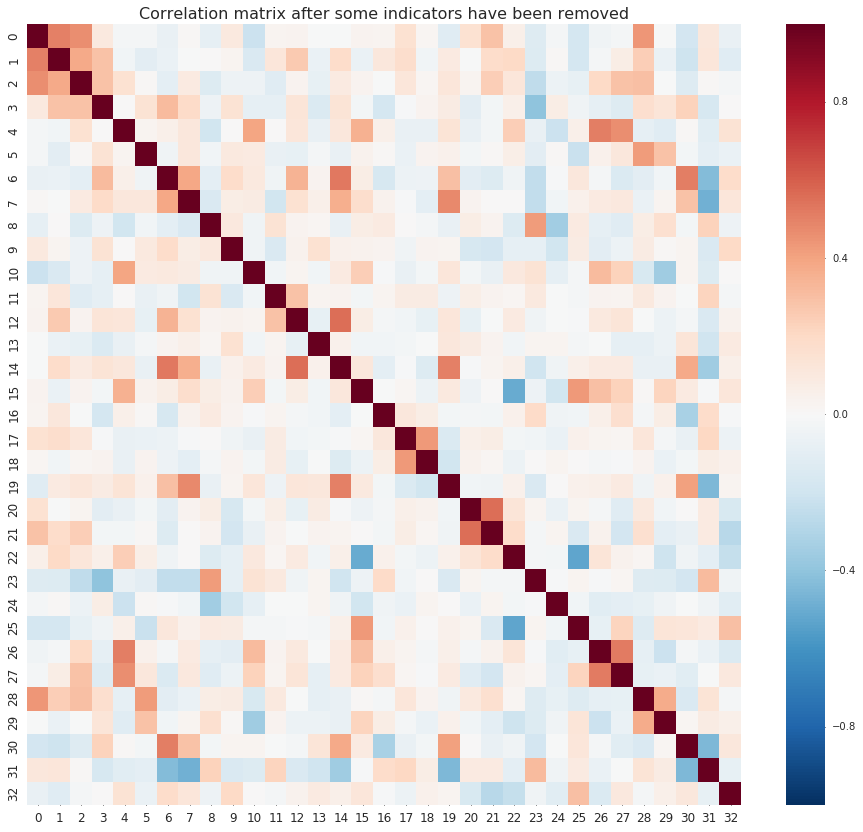

[(0, 'number_of_contacts_stop'),
 (1, 'number_of_contacts_text+call'),
 (2, 'number_of_interactions_stop'),
 (3, 'number_of_interactions_text+call'),
 (4, 'number_of_interactions_physical'),
 (5, 'percent_ei_percent_durations_stop'),
 (6, 'balance_of_interactions_text'),
 (7, 'duration_text'),
 (8, 'duration_screen'),
 (9, 'duration_call'),
 (10, 'duration_physical'),
 (11, 'percent_initiated_conversations_text_std'),
 (12, 'percent_initiated_conversations_text_mean'),
 (13, 'percent_initiated_conversations_call_std'),
 (14, 'percent_concluded_conversations_text_mean'),
 (15, 'overlap_conversations_physical'),
 (16, 'response_delay_text_std'),
 (17, 'response_delay_call_std'),
 (18, 'response_delay_call_mean'),
 (19, 'response_rate_text+call_std'),
 (20, 'percent_nocturnal_screen'),
 (21, 'percent_nocturnal_stop'),
 (22, 'percent_nocturnal_physical'),
 (23, 'interevent_time_screen'),
 (24, 'ratio_social_screen_alone_screen_physical+screen'),
 (25, 'ratio_interactions_campus_other_physi

In [67]:
plt.figure(figsize=(16,14))
plt.title("Correlation matrix after some indicators have been removed", fontsize=16)
sns.heatmap(pd.DataFrame(np.corrcoef(X.T)))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
[(i, '_'.join(n.split("__allweek__allday__"))) for i, n in enumerate(feat_names)]

In [31]:
pareto_cluster = Pareto_cluster(num_iter=10, sample_size=1.0, remove_outliers=True, visualize=True)
pareto_cluster.fit(X)

ImportError: No module named p2t

In [44]:
clusters_infomap = pareto_cluster.Infomap()
clusters_dbscan = pareto_cluster.DBSCAN()

3 clusters and 0 outliers
3 clusters and 1 outliers
3 clusters and 2 outliers
3 clusters and 3 outliers
3 clusters and 7 outliers
3 clusters and 8 outliers
3 clusters and 9 outliers
	... found 1 valid solutions, using eps=1.854227, min_samples=11 (minimal params)


In [49]:
clusters_dbscan

array([-1,  0, -1,  1, -1,  0, -1, -1,  1,  0,  1,  1,  1, -1,  1,  0, -1,
        2,  0,  2,  1,  0,  0,  0,  0,  0, -1,  2,  1,  2,  0,  1,  1,  1,
        1,  0,  2,  1, -1])

In [46]:
from itertools import groupby
import json

#clusters_dbscan = pareto_cluster.DBSCAN()

groups = []
for _, g in groupby(sorted(zip(clusters_dbscan, feat_names), key=lambda x: x[0]), key=lambda x: x[0]):
    groups.append([e[1] for e in g])

for g in groups:
    print json.dumps(g, indent=2)

[
  "number_of_contacts__allweek__allday__stop", 
  "number_of_contacts__allweek__allday__call", 
  "duration__allweek__allday__stop", 
  "duration__allweek__allday__screen", 
  "duration__allweek__allday__call", 
  "percent_concluded_conversations__allweek__allday__call+text_mean", 
  "overlap_conversations_per_contacts__allweek__allday__physical", 
  "entropy_per_contacts__allweek__allday__physical", 
  "overlap_screen_physical__allweek__allday__screen+physical"
]
[
  "number_of_contacts__allweek__allday__text", 
  "duration__allweek__allday__text", 
  "percent_nocturnal__allweek__allday__screen", 
  "overlap_conversations_per_contacts__allweek__allday__text", 
  "response_delay__allweek__allday__text_std", 
  "response_rate__allweek__allday__call+text_mean", 
  "response_rate__allweek__allday__call+text_std", 
  "entropy_per_contacts__allweek__allday__stop", 
  "entropy_per_contacts__allweek__allday__text", 
  "entropy_per_contacts__allweek__allday__call", 
  "interactions_per_conta

In [127]:
print feat_names[2]
print feat_names[30]

number_of_contacts__allweek__allday__call
number_of_interactions__allweek__allday__call


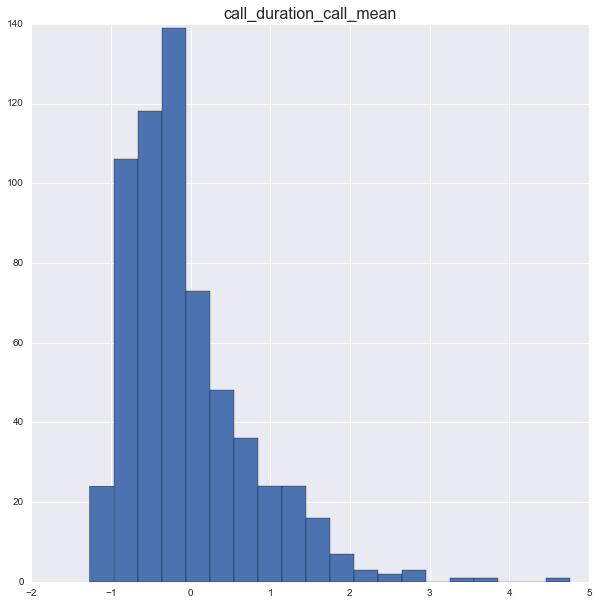

In [110]:
j = 4
plt.figure(figsize=(10,10))
plt.title(''.join(feat_names[j].split("_allweek__allday__")), fontsize=16)
plt.hist(X[:, j], bins=20)
plt.show()

In [512]:
def time_correlated_entropy(walk):
    counter = Counter(zip(walk[:-1], walk[1:]))
    P = np.array(counter.values(), float) / np.sum(counter.values())
    return - sum(P * np.log2(P))

def shannon_entropy(data):
    data = np.array(Counter(walk).values()) * 1.0/ len(data)
    data = data *1.0 / sum(data)
    return - sum(
        data * np.log2(data)
    )

In [ ]:
x_call, y_call, z_call = [], [], []
x_text, y_text, z_text = [], [], []
x_physical, y_physical, z_physical = [], [], []
x_stop, y_stop, z_stop = [], [], []
    
    walk = [r.correspondent_id for r in user.physical_records]
    n = len(set(walk))
    x_physical.append(n)
    y_physical.append(shannon_entropy(walk))
    z_physical.append(time_correlated_entropy(walk))
    
    walk = [r.correspondent_id for r in user.call_records]
    x_call.append(n)
    y_call.append(shannon_entropy(walk))
    z_call.append(time_correlated_entropy(walk))

    walk = [r.correspondent_id for r in user.text_records]
    x_text.append(n)
    y_text.append(shannon_entropy(walk))
    z_text.append(time_correlated_entropy(walk))
    
    walk = [r.position for r in user.stop_records]
    x_stop.append(n)
    y_stop.append(shannon_entropy(walk))
    z_stop.append(time_correlated_entropy(walk))

In [39]:
def _processed_users(tc):
    interaction_types = ["call", "text", "physical", "screen", "stop"]
    counter = Counter()
    for t in interaction_types:
        users = [int(f.split(".")[0]) for f in os.listdir("build_dataset/data_cache/records/%s/%s" % (t, tc))]
        counter.update(users)
    return [k for k,v in counter.items() if v == 5]

def _threshold_test(user):
    def __recs_per_day(records):
        counter = len(records) * 1.0
        span = (max(records, key=lambda r: r.datetime).datetime - \
                min(records, key=lambda r: r.datetime).datetime).days
        return counter/span
    
    thresholds = [
        (user.text_records, 2),
        (user.call_records, 1),
        (user.physical_records, 1),
        (user.screen_records, 20),
        (user.stop_records, 1)
    ]
    
    for records, thr in thresholds:
        if __recs_per_day(records) < thr:
            return False
    return True

users_records = {}
users_below_thresh = []
tc = "tc0"
for u in _processed_users(tc):
    user = bc_d.read_csv(
        "%d" % u, 
        call_path="build_dataset/data_cache/records/call/%s/" % tc,
        text_path="build_dataset/data_cache/records/text/%s/" % tc,
        physical_path="build_dataset/data_cache/records/physical/%s/" % tc,
        screen_path="build_dataset/data_cache/records/screen/%s/" % tc, 
        stop_path="build_dataset/data_cache/records/stop/%s/" % tc, 
        network=False,
        describe=False
    )
    try:
        if not _threshold_test(user):
            users_below_thresh.append(u)
            
        users_records[u] = {
            "call": len(user.call_records) * 1.0 / (max(user.call_records, key=lambda r: r.datetime).datetime - min(user.call_records, key=lambda r: r.datetime).datetime).days ,
            "text": len(user.text_records) * 1.0 / (max(user.text_records, key=lambda r: r.datetime).datetime - min(user.text_records, key=lambda r: r.datetime).datetime).days ,
            "physical": len(user.physical_records) * 1.0 / (max(user.physical_records, key=lambda r: r.datetime).datetime - min(user.physical_records, key=lambda r: r.datetime).datetime).days ,
            "screen": len(user.screen_records) * 1.0 / (max(user.screen_records, key=lambda r: r.datetime).datetime - min(user.screen_records, key=lambda r: r.datetime).datetime).days ,
            "stop": len(user.stop_records) * 1.0 / (max(user.stop_records, key=lambda r: r.datetime).datetime - min(user.stop_records, key=lambda r: r.datetime).datetime).days 
        }
    except ZeroDivisionError:
        print u
        users_below_thresh.append(u)

25
134
763
809
811


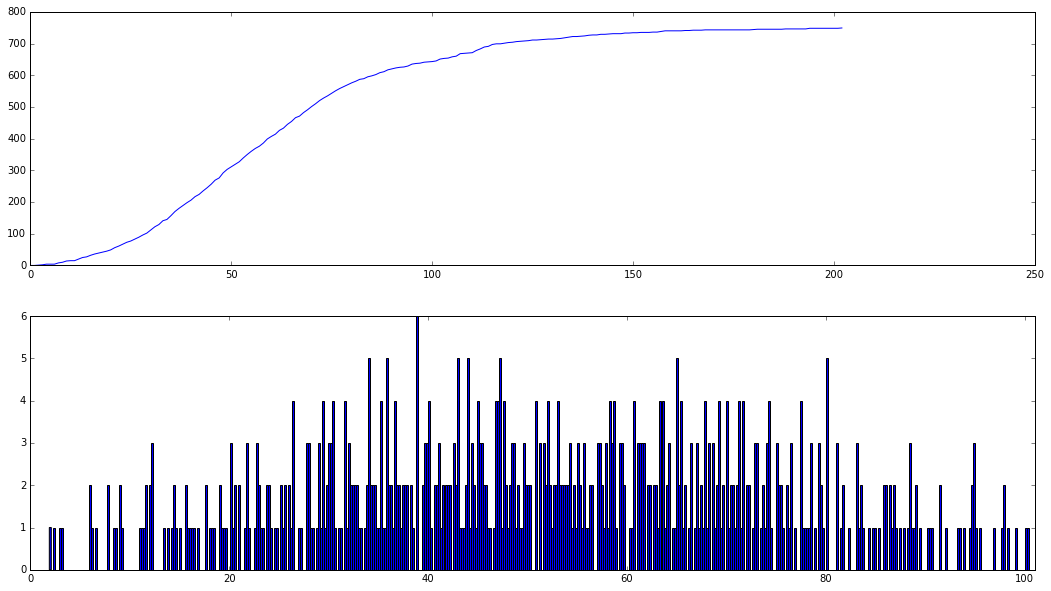

In [32]:
dtype="screen"
maxval = int(max([v[dtype] for v in users_records.values()])) + 1

y = []
for i in range(maxval):
    y.append(len([v[dtype] for v in users_records.values() if v[dtype] < i]))

plt.figure(figsize=(18,10))
plt.subplot(2,1,1)
plt.plot(range(maxval), y)
plt.subplot(2,1,2)
plt.hist([v[dtype] for _, v in users_records.items()], bins=1000)
plt.xlim([0, maxval/2])
plt.show()

In [40]:
len(users_below_thresh)

143

In [322]:
a, b = [], []

for u in range(500):
    tc = "tc0"
    user = bc_d.read_csv(
                "%d" % u, 
                #call_path="build_dataset/data_cache/records/call/%s/" % tc,
                #text_path="build_dataset/data_cache/records/text/%s/" % tc,
                physical_path="build_dataset/data_cache/records/physical/%s/" % tc,
                #screen_path="build_dataset/data_cache/records/screen/%s/" % tc, 
                stop_path="build_dataset/data_cache/records/stop/%s/" % tc, 
                network=False,
                describe=False
            )
    records = sorted(user.physical_records + user.stop_records, key=lambda r: r.datetime)
    try:
        x, y = percent_outside_campus_from_campus(records)
    except ZeroDivisionError:
        print u
        continue
    a.append(x)
    b.append(y)

41
60
176
212
260
316
417
454
484
490


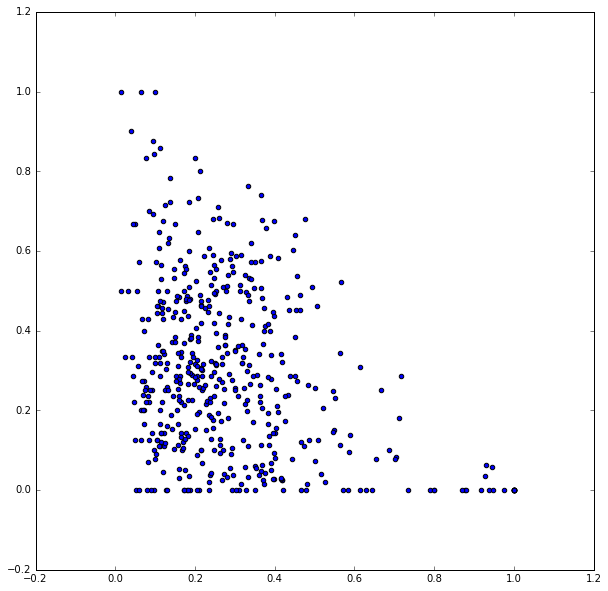

In [323]:
plt.figure(figsize=(10,10))
plt.scatter(a, b)
plt.show()

In [371]:
(dt.fromtimestamp(1111111111) - dt.fromtimestamp(1114111111)).days

-35

In [135]:
import datetime

def entropy(data):
    """
    Compute the Shannon entropy, a measure of uncertainty.
    """
    if len(data) == 0:
        return None
    _op = lambda f: f * np.log2(f)
    return - sum(_op(float(i) / sum(data)) for i in data)

def entropy_per_contacts(records, normalize=True):
    """Entropy of the user's contacts. Time uncorrelated.

    Parameters
    ----------
    normalize: boolean, default is False
        Returns a normalized entropy between 0 and 1.
    """
    try:
        counter = Counter(r.correspondent_id for r in records)
    except AttributeError:
        counter = Counter(r.position for r in records)

    raw_entropy = entropy(counter.values())
    n = len(counter)
    if normalize and n > 1:
        return raw_entropy / n
    else:
        return raw_entropy


x_call, y_call = [], []
x_text, y_text = [], []
x_physical, y_physical = [], []
x_screen, y_screen = [], []
x_stop, y_stop = [], []

tc = "tc0"
for u in _processed_users(tc):
    user = bc_d.read_csv(
        "%d" % u, 
        call_path="build_dataset/data_cache/records/call/%s/" % tc,
        text_path="build_dataset/data_cache/records/text/%s/" % tc,
        physical_path="build_dataset/data_cache/records/physical/%s/" % tc,
        #screen_path="build_dataset/data_cache/records/screen/%s/" % tc,
        stop_path="build_dataset/data_cache/records/stop/%s/" % tc,
        network=False,
        describe=False
    )
    
    x_call.append(entropy_per_contacts(user.call_records))
    y_call.append(len(user.call_records))

    x_text.append(entropy_per_contacts(user.text_records))
    y_text.append(len(user.text_records))

    x_physical.append(entropy_per_contacts(user.physical_records))
    y_physical.append(len(user.physical_records))

    x_stop.append(entropy_per_contacts(user.stop_records))
    y_stop.append(len(user.stop_records))

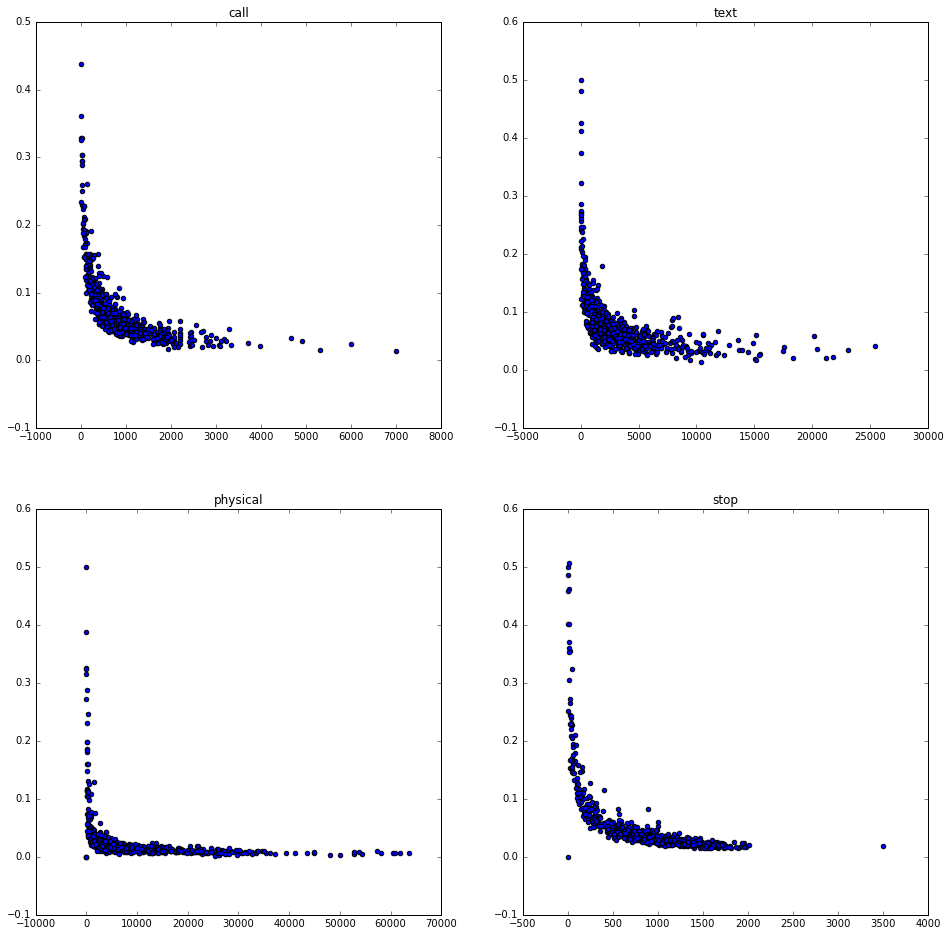

In [136]:
plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
plt.title("call")
plt.scatter(y_call, x_call)
plt.subplot(2, 2, 2)
plt.title("text")
plt.scatter(y_text, x_text)
plt.subplot(2, 2, 3)
plt.title("physical")
plt.scatter(y_physical, x_physical)
plt.subplot(2, 2, 4)
plt.title("stop")
plt.scatter(y_stop, x_stop)
plt.show()

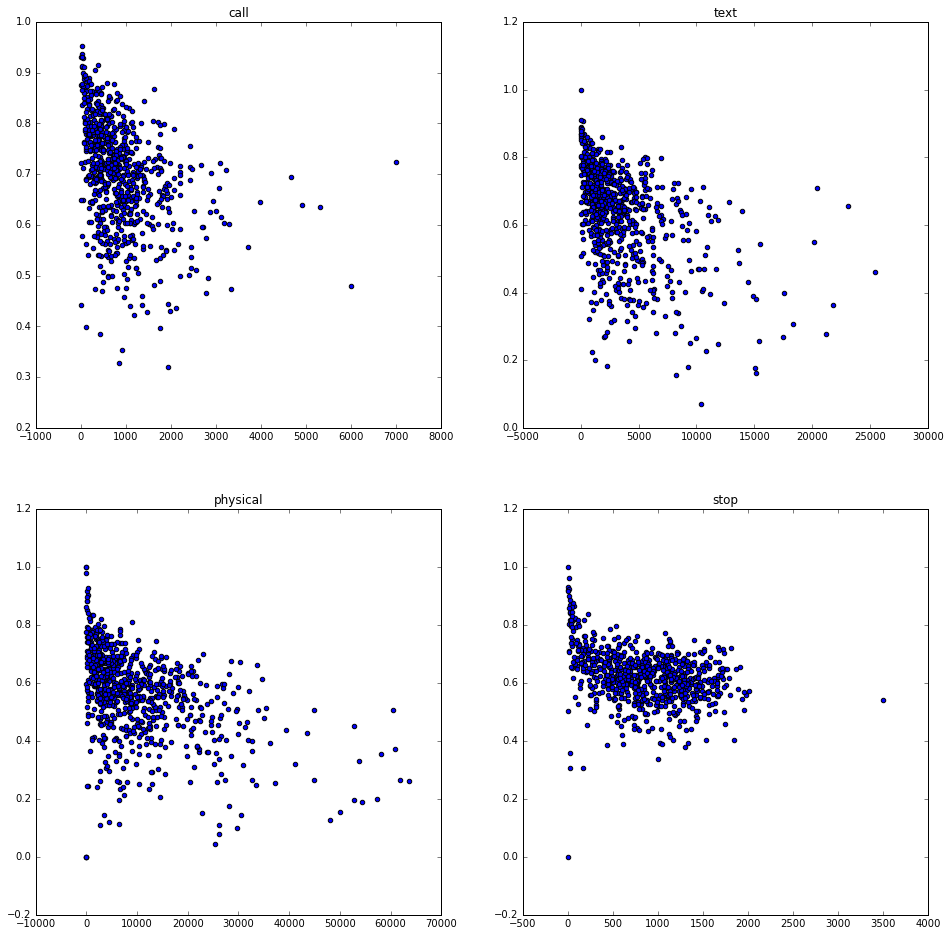

In [134]:
plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
plt.title("call")
plt.scatter(y_call, x_call)
plt.subplot(2, 2, 2)
plt.title("text")
plt.scatter(y_text, x_text)
plt.subplot(2, 2, 3)
plt.title("physical")
plt.scatter(y_physical, x_physical)
plt.subplot(2, 2, 4)
plt.title("stop")
plt.scatter(y_stop, x_stop)
plt.show()

In [52]:
import datetime
from collections import defaultdict
from scipy.stats import spearmanr

import math
def _conversations(group, delta=datetime.timedelta(hours=1)):
    """Return iterator of grouped conversations.

    See :ref:`Using bandicoot <conversations-label>` for a definition of conversations.

    A conversation begins when one person sends a text-message to the other and ends when one of them makes a phone call
    or there is no activity between them for an hour.  
    """
    last_time = None
    results = []
    for g in group:
        if last_time is None or g.datetime - last_time < delta:
            results.append(g)
            if g.interaction == "call" and g.duration > 1:
                yield results
                results = []

        else:
            if len(results) != 0:
                yield results
            results = [g]

        last_time = g.datetime

    if len(results) != 0:
        yield results
        
def _interaction_grouper(records, dtype=None):
    interactions = defaultdict(list)
    if dtype != "stop":
        for r in records:
            interactions[r.correspondent_id].append(r)
    else:
        for r in records:
            interactions[r.position].append(r)
    return interactions

        
def overlap_conversations(records):
    """Percent of conversation time that overlaps with other conversations.

    The following illustrates the concept of overlap. '-' denotes active conversation,
    '_' is idle time, and * underscores overlap. Each symbol is 1 minute.
        
        Conversation 1: ___-----______   # Overlap of two conversations. The total 
        Conversation 2: ______--------   # conversation time 11 minutes and overlap
        Conve. overlap:       **         # is 2 minutes: results in 2/11 overlap.

    #See :ref:`Using bandicoot <conversations-label>` for a definition of conversations.
    """
    records = list(records)
    interactions = _interaction_grouper(records)

    def _timespans(grouped):
        to_ts = lambda dt: int(dt.strftime("%s"))
        ts = [(to_ts(conv[0].datetime), to_ts(conv[-1].datetime))
              for conv in _conversations(grouped, delta=datetime.timedelta(hours=0.5))]
        return ts

    timestamps = [
        ts 
        for g in interactions.values()
        for a, b in _timespans(g) 
        for ts in xrange(a,b)
    ]
    
    if len(timestamps) == 0:
        return None
    
    return (1 - len(set(timestamps)) * 1.0 / len(timestamps))

In [ ]:
user = bc_d.read_csv(
    "%d" % 0, 
    #call_path="build_dataset/data_cache/records/call/%s/" % tc,
    #text_path="build_dataset/data_cache/records/text/%s/" % tc,
    physical_path="build_dataset/data_cache/records/physical/%s/" % tc,
    #screen_path="build_dataset/data_cache/records/screen/%s/" % tc,
    #stop_path="build_dataset/data_cache/records/stop/%s/" % tc,
    network=False,
    describe=False
)

In [51]:
records = sorted(user.text_records + user.call_records, key=lambda r: r.datetime)
percent_ei_percent_interactions(records)

0.014857142857142857

In [21]:
tmp

0.007979840403191937

In [419]:
records = sorted(user.physical_records, key=lambda r: r.datetime)
interaction_periodicity(records, thr=0.0)

(0.30669561270444889, 0.29667875508461428)

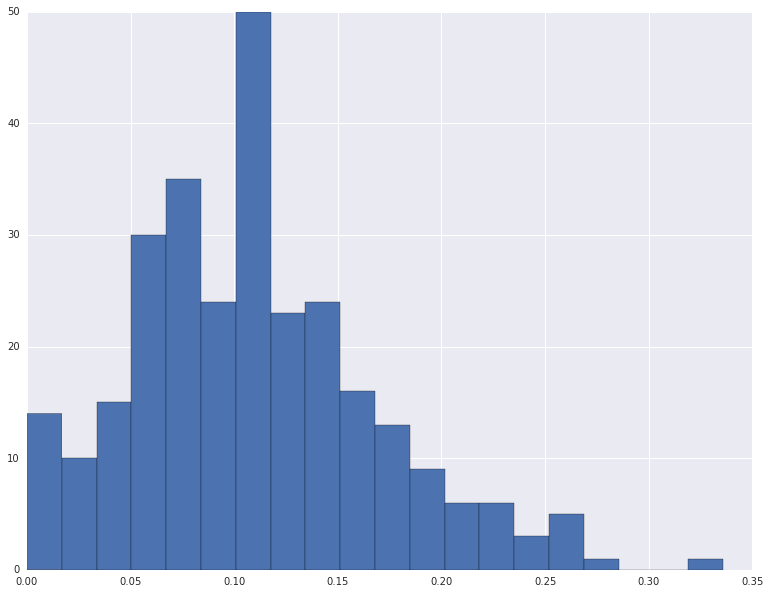

In [534]:
plt.figure(figsize=(13,10))
plt.hist(au_10, bins=20)
plt.show()

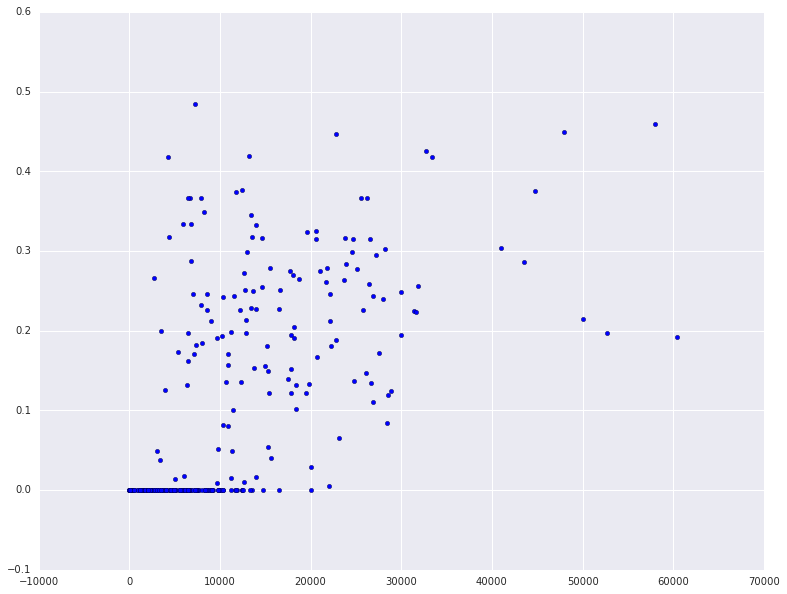

In [542]:
plt.figure(figsize=(13,10))
plt.scatter(num_interact, au_100)
plt.show()